# Import necessary packages

In [2]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy as np
print('numpy: %s' % np.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# theano
import theano
print('theano: %s' % theano.__version__)
# tensorflow
import tensorflow
print('tensorflow: %s' % tensorflow.__version__)
# keras
import keras
print('keras: %s' % keras.__version__)

scipy: 1.4.1
numpy: 1.18.1
matplotlib: 3.2.1
pandas: 1.0.3
statsmodels: 0.11.1
sklearn: 0.22.1
theano: 1.0.4


/Users/eason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/eason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/eason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/eason/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

tensorflow: 1.13.1
keras: 2.3.1


Using TensorFlow backend.


In [3]:
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import pandas as pd
import math
from matplotlib import pyplot

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Read Urban street dataset

In [5]:
dataset = pd.read_csv('ModelInput_urbanstreet.csv')
print(dataset.head(3))
print(dataset.shape)

   LinkID   AveSpeed   SDSpeed  Flow    Idling          CO2      NOx  \
0       1  17.662075  0.188579    17  0.002500   9788.87012  6.79266   
1       2  17.883052  0.202155    13  0.003373  14272.00000  9.90004   
2       3  13.225561  0.168020     7  0.002336   6329.77002  4.50777   

   linkLength  
0    0.270091  
1    0.524965  
2    0.511693  
(1258, 8)


In [6]:
#Filtering unreasonable values
dataset['Speed2'] = dataset['AveSpeed']**2
dataset['Speed3'] = dataset['AveSpeed']**2
dataset['CO2'] = dataset['CO2'] / dataset['Flow'] / dataset['linkLength']
dataset['NOx'] = dataset['NOx'] / dataset['Flow'] / dataset['linkLength']

dataset.dropna(inplace=True)

dataset = dataset[dataset['CO2'] <= np.percentile(dataset['CO2'],90)]

#greater_than_10 = dataset['AveSpeed'] > 10
#dataset = dataset[greater_than_10]

print(dataset.head(3))
print(dataset.shape)

   LinkID   AveSpeed   SDSpeed  Flow    Idling          CO2       NOx  \
0       1  17.662075  0.188579    17  0.002500  2131.930277  1.479382   
1       2  17.883052  0.202155    13  0.003373  2091.273797  1.450651   
2       3  13.225561  0.168020     7  0.002336  1767.179158  1.258503   

   linkLength      Speed2      Speed3  
0    0.270091  311.948893  311.948893  
1    0.524965  319.803559  319.803559  
2    0.511693  174.915457  174.915457  
(1120, 10)


# Split train and test datasets

In [77]:
train = dataset.sample(n=math.floor(0.8*dataset.shape[0]))
test = dataset.sample(n=math.ceil(0.2*dataset.shape[0]))

# Normalize data

In [78]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)

test = scaler.transform(test)
# summarize transformed data
np.set_printoptions(precision=3)
print(train)

[[0.382 0.554 0.106 ... 0.012 0.403 0.403]
 [0.2   0.84  0.042 ... 0.01  0.758 0.758]
 [0.398 0.878 0.05  ... 0.027 0.812 0.812]
 ...
 [0.044 0.369 0.121 ... 0.035 0.227 0.227]
 [0.869 0.549 0.279 ... 0.01  0.398 0.398]
 [0.066 0.797 0.126 ... 0.013 0.699 0.699]]


In [79]:
train = pd.DataFrame(data=train)
test = pd.DataFrame(data=test)
train.columns =['LinkID', 'AveSpeed', 'SDSpeed', 'Flow', 'Idling', 'CO2', 'NOx', 'linkLength', 'Speed2', 'Speed3']
test.columns =['LinkID', 'AveSpeed', 'SDSpeed', 'Flow', 'Idling', 'CO2', 'NOx', 'linkLength', 'Speed2', 'Speed3']

CO2_train = train['CO2']
NOx_train = train['NOx']
X_train = train[['AveSpeed','SDSpeed','Flow','Idling','Speed2','Speed3']]
#X_train = train[['AveSpeed','SDSpeed','Idling','Speed2','Speed3']]

CO2_test = test['CO2']
NOx_test = test['NOx']
X_test = test[['AveSpeed','SDSpeed','Flow','Idling','Speed2','Speed3']]
#X_test = test[['AveSpeed','SDSpeed','Idling','Speed2','Speed3']]

# Construct, compile and train model, use Mean Absolute Error as loss function

## Due to randomness of the ADAM optimizer, you may need to repeat the model several times to optimally tune the model

## CO2 model

In [80]:
model_CO2 = Sequential()
model_CO2.add(Dense(8,kernel_initializer='normal', input_dim=6, activation ='relu'))
model_CO2.add(Dense(6, kernel_initializer='normal', activation ='relu'))
model_CO2.add(Dense(4, kernel_initializer='normal', activation ='relu'))
model_CO2.add(Dense(1,kernel_initializer='normal',activation ='linear'))
model_CO2.compile(loss='mean_absolute_error', optimizer='adam')
#model_CO2.compile(loss='mean_squared_error', optimizer='adam')

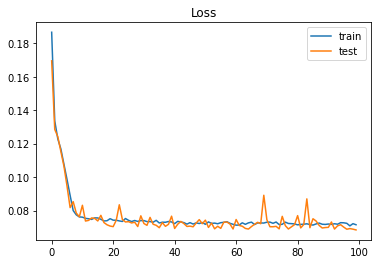

In [81]:
history = model_CO2.fit(X_train, CO2_train, validation_data=(X_test, CO2_test), epochs=100, batch_size=1, verbose =0)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
#pyplot.savefig('CO2_train.png')

In [82]:
CO2_test = CO2_test * (scaler.data_max_[5] - scaler.data_min_[5]) + scaler.data_min_[5]

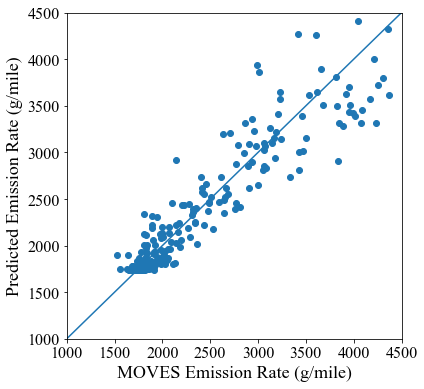

In [83]:
predictions = model_CO2.predict(X_test)
predictions = predictions * (scaler.data_max_[5] - scaler.data_min_[5]) + scaler.data_min_[5]
predictions.shape
fig = pyplot.figure(figsize=(6, 6))
pyplot.scatter(CO2_test,predictions)
abline_x = [0, 8000]
abline_y = [0, 8000]
pyplot.plot(abline_x,abline_y)
pyplot.xlim(1000, 4500)
pyplot.ylim(1000, 4500)
pyplot.xticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.yticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.xlabel('MOVES Emission Rate (g/mile)', fontname="Times New Roman", fontsize=18)
pyplot.ylabel('Predicted Emission Rate (g/mile)',fontname="Times New Roman", fontsize=18)
#fig.savefig('Urban_CO2_predict.png', dpi=fig.dpi, bbox_inches='tight')
pyplot.show()

In [84]:
mean_absolute_percentage_error(CO2_test,predictions)

33.22561674800163

## NOx model

In [85]:
model_NOx = Sequential()
model_NOx.add(Dense(8,kernel_initializer='normal', input_dim=6, activation ='relu'))
model_NOx.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_NOx.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_NOx.add(Dense(1,kernel_initializer='normal',activation ='linear'))
model_NOx.compile(loss='mean_absolute_error', optimizer='adam')

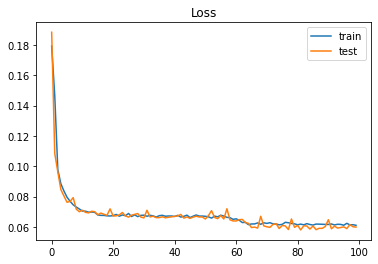

In [86]:
history = model_NOx.fit(X_train, NOx_train, validation_data=(X_test, NOx_test), epochs=100, batch_size=1, verbose =0)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [87]:
NOx_test = NOx_test * (scaler.data_max_[6] - scaler.data_min_[6]) + scaler.data_min_[6]

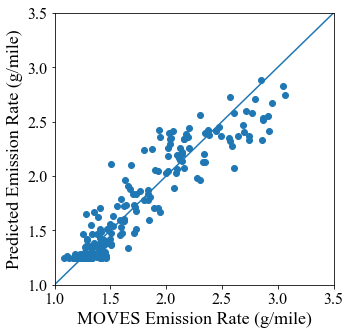

In [88]:
predictions = model_NOx.predict(X_test)
predictions = predictions * (scaler.data_max_[6] - scaler.data_min_[6]) + scaler.data_min_[6]
predictions.shape
fig = pyplot.figure(figsize=(5, 5))
pyplot.scatter(NOx_test,predictions)
abline_x = [0, 8000]
abline_y = [0, 8000]
pyplot.plot(abline_x,abline_y)
pyplot.xlim(1, 3.5)
pyplot.ylim(1, 3.5)
pyplot.xticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.yticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.xlabel('MOVES Emission Rate (g/mile)', fontname="Times New Roman", fontsize=18)
pyplot.ylabel('Predicted Emission Rate (g/mile)',fontname="Times New Roman", fontsize=18)
fig.savefig('Urban_NOx_predict.png', dpi=fig.dpi, bbox_inches='tight')
pyplot.show()

In [89]:
mean_absolute_percentage_error(NOx_test,predictions)

31.526653001902105

# Read highway dataset

In [71]:
dataset = pd.read_csv('ModelInput_highway.csv')
print(dataset.head(3))
print(dataset.shape)

   LinkID   AveSpeed   SDSpeed  Flow    Idling            CO2         NOx  \
0       1  11.094211  0.432298    12  0.000000     816.072021    0.532522   
1       2  25.517518  0.172613   358  0.002439  169428.000000  118.121002   
2       3  18.393659  0.453175   121  0.000000    5263.660156    3.475820   

   linkLength  
0    0.013074  
1    0.310835  
2    0.023886  
(1119, 8)


In [72]:
dataset['Speed2'] = dataset['AveSpeed']**2
dataset['Speed3'] = dataset['AveSpeed']**2
dataset['CO2'] = dataset['CO2'] / dataset['Flow'] / dataset['linkLength']
dataset['NOx'] = dataset['NOx'] / dataset['Flow'] / dataset['linkLength']
dataset.dropna(inplace=True)

dataset = dataset[dataset['CO2'] <= np.percentile(dataset['CO2'],90)]
print(dataset.head(3))
print(dataset.shape)

   LinkID   AveSpeed   SDSpeed  Flow    Idling          CO2       NOx  \
1       2  25.517518  0.172613   358  0.002439  1522.554200  1.061487   
2       3  18.393659  0.453175   121  0.000000  1821.243907  1.202645   
3       4  23.872283  0.292561    84  0.010870  1813.505791  1.248282   

   linkLength      Speed2      Speed3  
1    0.310835  651.143740  651.143740  
2    0.023886  338.326674  338.326674  
3    0.025215  569.885877  569.885877  
(1003, 10)


In [73]:
train = dataset.sample(n=math.floor(0.8*dataset.shape[0]))
test = dataset.sample(n=math.ceil(0.2*dataset.shape[0]))

In [74]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train)
train = scaler.transform(train)

test = scaler.transform(test)
# summarize transformed data
np.set_printoptions(precision=3)
print(train)

[[0.556 0.476 0.086 ... 0.007 0.267 0.267]
 [0.656 0.914 0.053 ... 0.034 0.847 0.847]
 [0.215 0.373 0.159 ... 0.011 0.177 0.177]
 ...
 [0.068 0.613 0.086 ... 0.007 0.414 0.414]
 [0.018 0.58  0.114 ... 0.007 0.376 0.376]
 [0.509 1.    0.032 ... 0.042 1.    1.   ]]


In [75]:
train = pd.DataFrame(data=train)
test = pd.DataFrame(data=test)
train.columns =['LinkID', 'AveSpeed', 'SDSpeed', 'Flow', 'Idling', 'CO2', 'NOx', 'linkLength', 'Speed2', 'Speed3']
test.columns =['LinkID', 'AveSpeed', 'SDSpeed', 'Flow', 'Idling', 'CO2', 'NOx', 'linkLength', 'Speed2', 'Speed3']

CO2_train = train['CO2']
NOx_train = train['NOx']
X_train = train[['AveSpeed','SDSpeed','Flow','Idling','Speed2','Speed3']]
#X_train = train[['AveSpeed','SDSpeed','Idling','Speed2','Speed3']]

CO2_test = test['CO2']
NOx_test = test['NOx']
X_test = test[['AveSpeed','SDSpeed','Flow','Idling','Speed2','Speed3']]
#X_test = test[['AveSpeed','SDSpeed','Idling','Speed2','Speed3']]

In [76]:
model_CO2 = Sequential()
model_CO2.add(Dense(8,kernel_initializer='normal', input_dim=6, activation ='relu'))
model_CO2.add(Dense(6, kernel_initializer='normal', activation ='relu'))
model_CO2.add(Dense(4, kernel_initializer='normal', activation ='relu'))
model_CO2.add(Dense(1,kernel_initializer='normal',activation ='linear'))
model_CO2.compile(loss='mean_absolute_error', optimizer='adam')

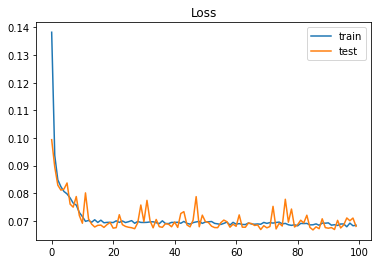

In [77]:
history = model_CO2.fit(X_train, CO2_train, validation_data=(X_test, CO2_test), epochs=100, batch_size=1, verbose =0)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
#pyplot.savefig('CO2_train.png')

In [78]:
CO2_test = CO2_test * (scaler.data_max_[5] - scaler.data_min_[5]) + scaler.data_min_[5]

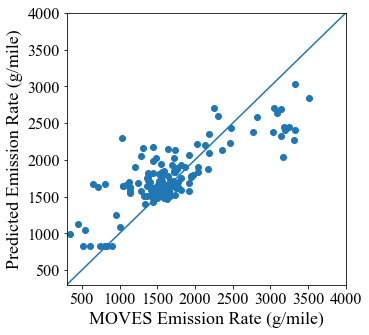

In [81]:
predictions = model_CO2.predict(X_test)
predictions = predictions * (scaler.data_max_[5] - scaler.data_min_[5]) + scaler.data_min_[5]
predictions.shape
fig = pyplot.figure(figsize=(5, 5))
pyplot.scatter(CO2_test,predictions)
abline_x = [0, 8000]
abline_y = [0, 8000]
pyplot.plot(abline_x,abline_y)
pyplot.xlim(300, 4000)
pyplot.ylim(300, 4000)
pyplot.xticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.yticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.xlabel('MOVES Emission Rate (g/mile)', fontname="Times New Roman", fontsize=18)
pyplot.ylabel('Predicted Emission Rate (g/mile)',fontname="Times New Roman", fontsize=18)
fig.savefig('Highway_CO2_predict.png', dpi=fig.dpi, bbox_inches='tight')
pyplot.show()

In [82]:
mean_absolute_percentage_error(CO2_test,predictions)

33.21663722476454

In [83]:
model_NOx = Sequential()
model_NOx.add(Dense(9,kernel_initializer='normal', input_dim=6, activation ='relu'))
model_NOx.add(Dense(5, kernel_initializer='normal', activation ='relu'))
model_NOx.add(Dense(3, kernel_initializer='normal', activation ='relu'))
model_NOx.add(Dense(1,kernel_initializer='normal',activation ='linear'))
model_NOx.compile(loss='mean_absolute_error', optimizer='adam')

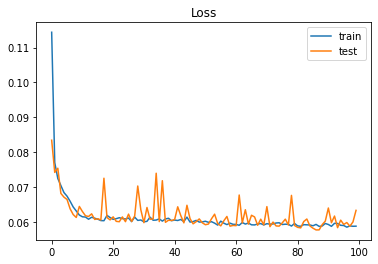

In [84]:
history = model_NOx.fit(X_train, NOx_train, validation_data=(X_test, NOx_test), epochs=100, batch_size=1, verbose =0)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

In [85]:
NOx_test = NOx_test * (scaler.data_max_[6] - scaler.data_min_[6]) + scaler.data_min_[6]

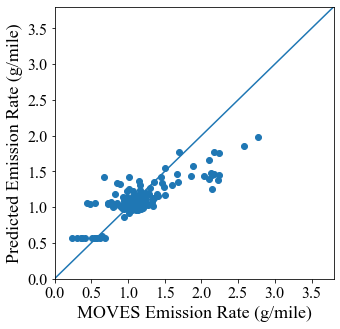

In [86]:
predictions = model_NOx.predict(X_test)
predictions = predictions * (scaler.data_max_[6] - scaler.data_min_[6]) + scaler.data_min_[6]
predictions.shape
fig = pyplot.figure(figsize=(5, 5))
pyplot.scatter(NOx_test,predictions)
abline_x = [0, 8000]
abline_y = [0, 8000]
pyplot.plot(abline_x,abline_y)
pyplot.xlim(0, 3.8)
pyplot.ylim(0, 3.8)
pyplot.xticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.yticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.xlabel('MOVES Emission Rate (g/mile)', fontname="Times New Roman", fontsize=18)
pyplot.ylabel('Predicted Emission Rate (g/mile)',fontname="Times New Roman", fontsize=18)
fig.savefig('Highway_NOx_predict.png', dpi=fig.dpi, bbox_inches='tight')
pyplot.show()

In [160]:
mean_absolute_percentage_error(NOx_test,predictions)

230751.77056421386

# Germany City Urban Streets
## Remember to apply the correct moedels: urban street models

In [90]:
valid_data = pd.read_csv('ModelInput_urbanstreet_G.csv')
valid_data['Speed2'] = valid_data['AveSpeed']**2
valid_data['Speed3'] = valid_data['AveSpeed']**2
valid_data['CO2'] = valid_data['CO2'] / valid_data['Flow'] / valid_data['linkLength']
valid_data['NOx'] = valid_data['NOx'] / valid_data['Flow'] / valid_data['linkLength']
valid_data.dropna(inplace=True)
valid_data = valid_data[valid_data['CO2'] <= np.percentile(dataset['CO2'],90)]
print(valid_data.head(3))
print(valid_data.shape)

   LinkID   AveSpeed   SDSpeed  Flow    Idling          CO2       NOx  \
3       4  11.867583  0.200816   238  0.004509  2600.792523  1.850761   
5       6  12.424083  0.165114   247  0.004861  2017.438575  1.480113   
6       7   6.217269  0.405115    22  0.068273  2835.984736  1.950962   

   linkLength      Speed2      Speed3  
3    0.042446  140.839536  140.839536  
5    0.098394  154.357847  154.357847  
6    0.048368   38.654435   38.654435  
(819, 10)


In [91]:
CO2_valid = valid_data['CO2']
NOx_valid = valid_data['NOx']
valid_test = scaler.transform(valid_data)
valid_test = pd.DataFrame(data=valid_test)
valid_test.columns =['LinkID', 'AveSpeed', 'SDSpeed', 'Flow', 'Idling', 'CO2', 'NOx', 'linkLength', 'Speed2', 'Speed3']

X_valid = valid_test[['AveSpeed','SDSpeed','Flow','Idling','Speed2','Speed3']]

In [92]:
predictions = model_CO2.predict(X_valid)
predictions = predictions * (scaler.data_max_[5] - scaler.data_min_[5]) + scaler.data_min_[5]
predictions.shape
print(CO2_valid)
print(predictions)

3       2600.792523
5       2017.438575
6       2835.984736
7       1814.113993
8       1798.271096
           ...     
1329    2525.216063
1332    3011.399477
1333    2643.087263
1334    2071.581114
1335    2304.491351
Name: CO2, Length: 819, dtype: float64
[[2823.574]
 [2388.281]
 [3990.052]
 [3145.905]
 [3223.152]
 [4244.226]
 [4149.53 ]
 [3293.835]
 [5825.184]
 [3285.071]
 [3597.931]
 [3337.503]
 [4363.608]
 [3879.197]
 [3298.768]
 [3480.04 ]
 [3426.952]
 [3676.836]
 [2681.29 ]
 [2546.173]
 [3270.669]
 [3433.867]
 [3594.254]
 [4103.36 ]
 [2609.913]
 [2699.188]
 [3232.379]
 [2422.424]
 [3830.008]
 [2218.859]
 [2461.604]
 [2515.554]
 [2245.913]
 [2232.808]
 [2299.78 ]
 [4455.442]
 [3515.017]
 [3299.027]
 [3490.823]
 [3295.149]
 [3059.537]
 [3531.734]
 [2456.944]
 [4827.148]
 [3192.122]
 [3657.257]
 [3526.498]
 [3230.608]
 [3348.062]
 [3530.384]
 [3609.884]
 [3399.621]
 [3584.504]
 [2970.816]
 [3100.036]
 [3447.768]
 [2541.708]
 [2626.15 ]
 [2455.836]
 [3375.688]
 [2724.106]
 [3975.48

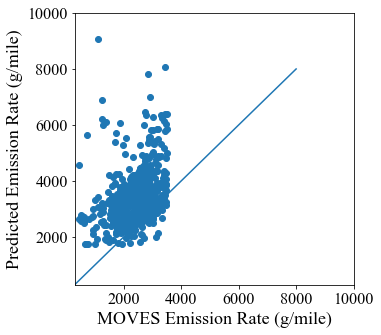

In [94]:
fig = pyplot.figure(figsize=(5, 5))
pyplot.scatter(CO2_valid,predictions)
abline_x = [0, 8000]
abline_y = [0, 8000]
pyplot.plot(abline_x,abline_y)
pyplot.xlim(300, 10000)
pyplot.ylim(300, 10000)
pyplot.xticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.yticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.xlabel('MOVES Emission Rate (g/mile)', fontname="Times New Roman", fontsize=18)
pyplot.ylabel('Predicted Emission Rate (g/mile)',fontname="Times New Roman", fontsize=18)
fig.savefig('Highway_CO2_predict.png', dpi=fig.dpi, bbox_inches='tight')
pyplot.show()

In [95]:
predictions = model_NOx.predict(X_valid)
predictions = predictions * (scaler.data_max_[6] - scaler.data_min_[6]) + scaler.data_min_[6]
predictions.shape
print(NOx_valid)
print(predictions)

3       1.850761
5       1.480113
6       1.950962
7       1.431985
8       1.430258
          ...   
1329    1.809693
1332    2.074778
1333    1.879927
1334    1.498019
1335    1.513023
Name: NOx, Length: 819, dtype: float64
[[2.139]
 [1.805]
 [2.561]
 [2.335]
 [2.381]
 [2.535]
 [2.526]
 [2.395]
 [2.944]
 [2.379]
 [2.462]
 [2.392]
 [2.624]
 [2.513]
 [2.415]
 [2.414]
 [2.401]
 [2.442]
 [1.988]
 [1.94 ]
 [2.376]
 [2.42 ]
 [2.466]
 [2.558]
 [2.   ]
 [2.066]
 [2.374]
 [1.814]
 [2.511]
 [1.601]
 [1.902]
 [1.94 ]
 [1.65 ]
 [1.65 ]
 [1.705]
 [2.57 ]
 [2.454]
 [2.419]
 [2.438]
 [2.384]
 [2.261]
 [2.45 ]
 [1.874]
 [2.734]
 [2.38 ]
 [2.449]
 [2.457]
 [2.382]
 [2.424]
 [2.456]
 [2.458]
 [2.444]
 [2.446]
 [2.157]
 [2.24 ]
 [2.511]
 [1.995]
 [2.108]
 [1.922]
 [2.397]
 [1.939]
 [2.491]
 [2.465]
 [2.199]
 [1.979]
 [1.947]
 [2.413]
 [2.163]
 [1.938]
 [2.47 ]
 [2.745]
 [2.464]
 [2.643]
 [1.747]
 [2.061]
 [1.97 ]
 [2.379]
 [2.287]
 [2.401]
 [2.465]
 [2.052]
 [2.394]
 [2.429]
 [2.378]
 [2.373]
 [2.499]


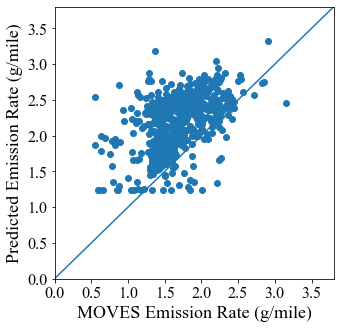

In [96]:
fig = pyplot.figure(figsize=(5, 5))
pyplot.scatter(NOx_valid,predictions)
abline_x = [0, 8000]
abline_y = [0, 8000]
pyplot.plot(abline_x,abline_y)
pyplot.xlim(0, 3.8)
pyplot.ylim(0, 3.8)
pyplot.xticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.yticks(fontsize=16,fontname="Times New Roman", rotation=0)
pyplot.xlabel('MOVES Emission Rate (g/mile)', fontname="Times New Roman", fontsize=18)
pyplot.ylabel('Predicted Emission Rate (g/mile)',fontname="Times New Roman", fontsize=18)
fig.savefig('Highway_NOx_predict.png', dpi=fig.dpi, bbox_inches='tight')
pyplot.show()

# RandomForest to test variable importance

In [74]:
import sklearn.ensemble
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.ensemble.forest import RandomForestRegressor
import numpy as np

/Users/eason/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [97]:
#X_train,y_train,X_test,y_test = train_test_split(data,test_size=0.3)
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100))
sel.fit(X_train, CO2_train)
sel.get_support()
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)
print(selected_feat)
#pd.series(sel.estimator_,feature_importances_,ravel()).hist()
importances = sel.feature_importances_
std = np.std([tree.feature_importances_ for tree in sel.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Index(['SDSpeed'], dtype='object')


AttributeError: 'SelectFromModel' object has no attribute 'feature_importances_'

In [98]:
#X_train,y_train,X_test,y_test = train_test_split(data,test_size=0.3)
sel = RandomForestRegressor(n_estimators = 1000)
sel.fit(X_train, CO2_train)
#sel.get_support()
#selected_feat= X_train.columns[(sel.get_support())]
#len(selected_feat)
#print(selected_feat)
#pd.series(sel.estimator_,feature_importances_,ravel()).hist()
importances = sel.feature_importances_
std = np.std([tree.feature_importances_ for tree in sel.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.657323)
2. feature 4 (0.089418)
3. feature 5 (0.087535)
4. feature 0 (0.084879)
5. feature 3 (0.043511)
6. feature 2 (0.037334)


In [99]:
#X_train,y_train,X_test,y_test = train_test_split(data,test_size=0.3)
sel = RandomForestRegressor(n_estimators = 1000)
sel.fit(X_train, NOx_train)
#sel.get_support()
#selected_feat= X_train.columns[(sel.get_support())]
#len(selected_feat)
#print(selected_feat)
#pd.series(sel.estimator_,feature_importances_,ravel()).hist()
importances = sel.feature_importances_
std = np.std([tree.feature_importances_ for tree in sel.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 1 (0.648177)
2. feature 5 (0.094224)
3. feature 0 (0.090324)
4. feature 4 (0.088204)
5. feature 3 (0.041429)
6. feature 2 (0.037641)


# Meso data to OP mode

In [8]:
dataset = pd.read_csv('MesoInput_urban.csv')
print(dataset.head(3))
print(dataset.shape)

   LinkID  AvgSpeedMps1  AvgSpeedMps2  AvgSpeedMps3  AvgSpeedMps4  \
0       1     20.501639           0.0           0.0     17.570926   
1       2     20.971391           0.0           0.0     18.199704   
2       3     15.541731           0.0           0.0      0.000000   

   AvgSpeedMps5  AvgSpeedMps6  AvgSpeedMps7  AvgSpeedMps8  AvgSpeedMps9  ...  \
0     15.403617     17.596170     17.700638     17.801087           0.0  ...   
1     15.195185     14.807143     18.055765     17.518511           0.0  ...   
2     14.576429      0.000000      0.000000     16.328367           0.0  ...   

   OpMode28  OpMode29  OpMode30  OpMode33  OpMode34  OpMode35  OpMode37  \
0  0.057500  0.032500  0.105000  0.010000      0.01  0.000000  0.007500   
1  0.052277  0.023609  0.091062  0.016863      0.00  0.008432  0.010118   
2  0.028037  0.004673  0.002336  0.000000      0.00  0.000000  0.000000   

   OpMode38  OpMode39  OpMode40  
0  0.005000  0.002500  0.012500  
1  0.003373  0.015177  0.015177  

In [66]:
train = dataset.sample(n=math.floor(0.8*dataset.shape[0]))
test = dataset.sample(n=math.ceil(0.2*dataset.shape[0]))

X_train = train[[ "AvgSpeedMps1","AvgSpeedMps2","AvgSpeedMps3","AvgSpeedMps4","AvgSpeedMps5","AvgSpeedMps6","AvgSpeedMps7","AvgSpeedMps8","AvgSpeedMps9","AvgSpeedMps10","AvgSpeedMps11","AvgSpeedMps12",
    "Vol1","Vol2","Vol3","Vol4","Vol5","Vol6","Vol7","Vol8","Vol9","Vol10","Vol11","Vol12",
    "Idling1","Idling2","Idling3","Idling4","Idling5","Idling6","Idling7","Idling8","Idling9","Idling10","Idling11","Idling12",
    "SpeedVar1","SpeedVar2","SpeedVar3","SpeedVar4","SpeedVar5","SpeedVar6","SpeedVar7","SpeedVar8","SpeedVar9","SpeedVar10","SpeedVar11","SpeedVar12"]]
Y_train = train[['OpMode34']]

X_test = test[[ "AvgSpeedMps1","AvgSpeedMps2","AvgSpeedMps3","AvgSpeedMps4","AvgSpeedMps5","AvgSpeedMps6","AvgSpeedMps7","AvgSpeedMps8","AvgSpeedMps9","AvgSpeedMps10","AvgSpeedMps11","AvgSpeedMps12",
    "Vol1","Vol2","Vol3","Vol4","Vol5","Vol6","Vol7","Vol8","Vol9","Vol10","Vol11","Vol12",
    "Idling1","Idling2","Idling3","Idling4","Idling5","Idling6","Idling7","Idling8","Idling9","Idling10","Idling11","Idling12",
    "SpeedVar1","SpeedVar2","SpeedVar3","SpeedVar4","SpeedVar5","SpeedVar6","SpeedVar7","SpeedVar8","SpeedVar9","SpeedVar10","SpeedVar11","SpeedVar12"]]
Y_test = test[['OpMode34']]
#print(X_train.head(3))
#print(Y_train.head(3))

In [67]:
# For accelerating status
model_OP0 = Sequential()
model_OP0.add(Dense(60,kernel_initializer='normal', input_dim=48, activation ='relu'))
model_OP0.add(Dense(40, kernel_initializer='normal', activation ='relu'))
model_OP0.add(Dense(20, kernel_initializer='normal', activation ='relu'))
model_OP0.add(Dense(1,kernel_initializer='normal',activation ='linear'))
model_OP0.compile(loss='mean_absolute_error', optimizer='adam')

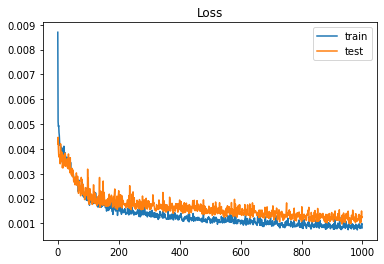

In [68]:
history = model_OP0.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=1000, batch_size=32,verbose=0)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

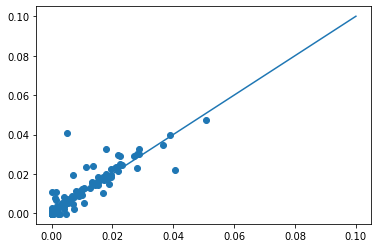

In [70]:
pre = model_OP0.predict(X_test)
abline_x = [0,0.1]
abline_y = [0,0.1]
pyplot.scatter(Y_test,pre)
pyplot.plot(abline_x,abline_y)
pyplot.show()